# Corrective RAG

- Corrective-RAG (CRAG) is a strategy for RAG by adding an intelligent evaluation and correction layer to improve the accuracy and reliability of responses, reducing hallucinations.

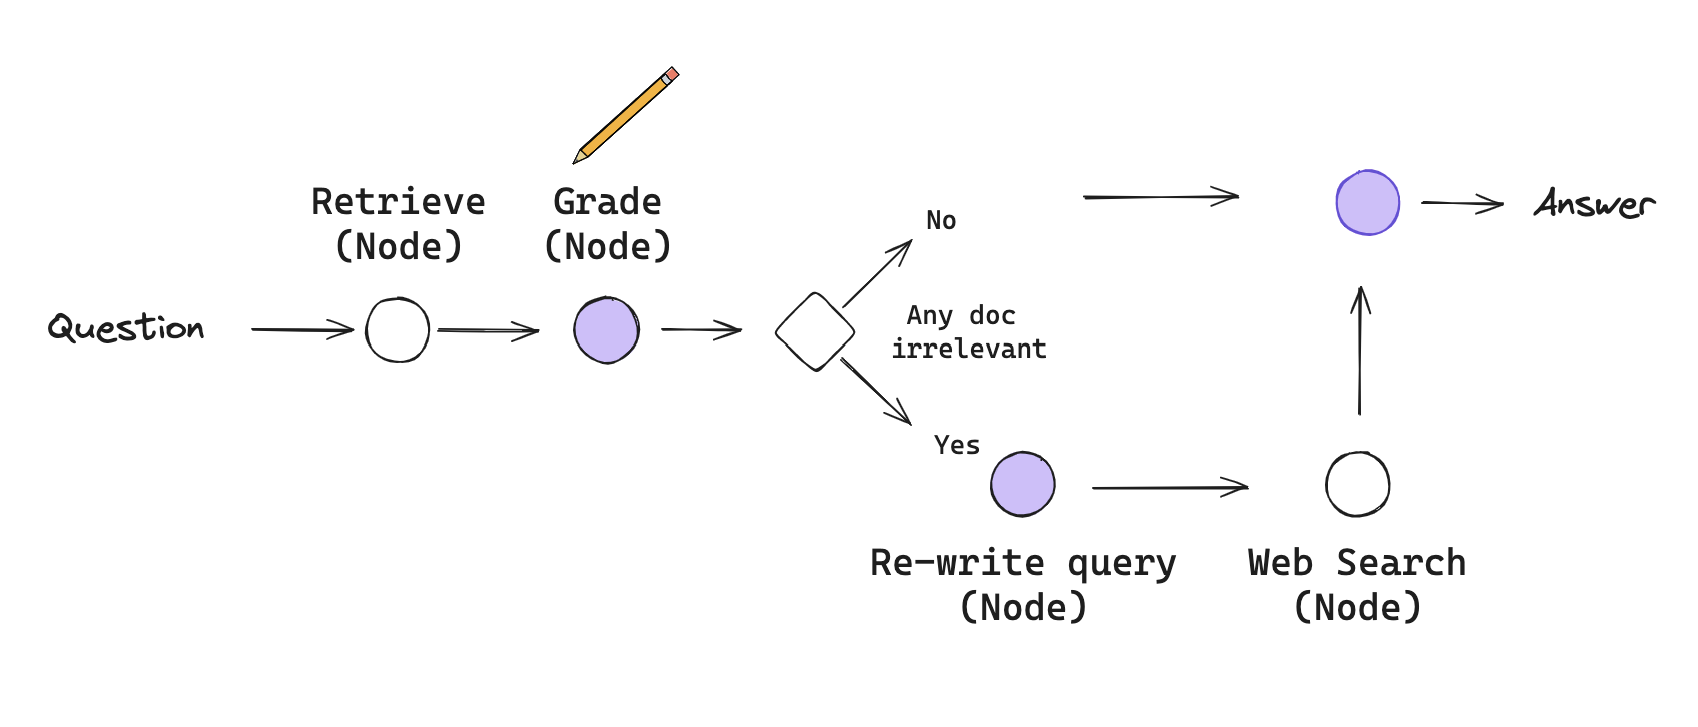

In [64]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
import os
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [65]:
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.document_loaders import WebBaseLoader
from langchain_classic.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

In [66]:
urls=[
    "https://docs.langchain.com/oss/python/langchain/rag",
    "https://docs.langchain.com/oss/python/langchain/sql-agent",
    "https://docs.langchain.com/oss/python/langchain/supervisor",
    "https://docs.langchain.com/oss/python/langchain/voice-agent"
]

docs=[WebBaseLoader(url).load() for url in urls]



In [67]:

docs_list=[item for sublist in docs for item in sublist]


In [68]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000,chunk_overlap=200)
embeddings=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")
llm=ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm.invoke("hi")

AIMessage(content="Hi! How's it going? Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 11, 'total_tokens': 34, 'completion_time': 0.059010737, 'prompt_time': 0.000213736, 'queue_time': 0.370547505, 'total_time': 0.059224473}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--41bf7d89-08ff-46e8-8340-91ade6270f6d-0', usage_metadata={'input_tokens': 11, 'output_tokens': 23, 'total_tokens': 34})

In [69]:
doc_splits=text_splitter.split_documents(docs_list)

vector_store=FAISS.from_documents(doc_splits,embeddings)

retriever=vector_store.as_retriever()

In [70]:
retriever.invoke("what is sql agent")

[Document(id='477a34d4-0f35-432a-a655-283780072efd', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/sql-agent', 'title': 'Build a SQL agent - Docs by LangChain', 'language': 'en'}, page_content='Build a SQL agent - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...‚åòKSupportGitHubTry LangSmithTry LangSmithSearch...NavigationLangChainBuild a SQL agentLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonLearnTutorialsLangChainSemantic searchRAG agentSQL agentVoice agentMulti-agentLangGraphConceptual overviewsComponent architectureMemoryContextGraph APIFunctional APIAdditional resourcesLangChain AcademyCase studiesGet helpOn this pageOverviewConceptsSetupInstallationLangSmith1. Select an LLM2. Configure the database3. Add tools for database interactions4. Use create_agent5. Run the agent(Optional) Use Studio6. Implement human-in-the-loop reviewNext stepsTutorialsLangChainBuild a SQL agentCopy pageCopy pag

#### GRAPH STATE

In [71]:
from typing import List
from langchain_classic.schema import Document
from typing_extensions import TypedDict
class GraphState(TypedDict):
    " Represents the state of the graph"

    question:str
    generation:str
    web_search:str
    documents:List[Document]
    

#### RETRIEVE NODE

In [72]:
def retrieve(state):
    "Retrieve documents from the vector store by using retriever"

    print("---RETRIEVE---")
    question=state["question"]

    documents=retriever.invoke(question)


    return {"documents":documents,"question":question}

#### DOCUMENTS GRADING NODE

In [73]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

def grade(state):
    "Checks whether the retrieved documents are relevant to the question"
    print("---CHECK DOCUMENT RELEVANCE TO THE QUERY---")

    class GradeDocuments(BaseModel):
        """Binary score for relevance check on retrieved documents."""

        binary_score: str = Field(
            description="Documents are relevant to the question, 'yes' or 'no'"
        )

    llm_grader=llm.with_structured_output(GradeDocuments)

    
    # Prompt
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )
    retrieval_grader=grade_prompt|llm_grader

    question=state["question"]
    documents=state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
    grade = score.binary_score
    if grade == "yes":
        print("---GRADE: DOCUMENT RELEVANT---")
        filtered_docs.append(d)
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        web_search = "Yes"
        

    return {"documents": filtered_docs, "question": question, "web_search": web_search}



In [74]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)

In [75]:
from langchain_core.output_parsers import StrOutputParser


rag_chain=prompt|llm


#### GENERATE NODE

In [76]:
def generate(state):
    " generate answer "

    print("---Generate---")
    question=state["question"]
    documents=state["documents"]


    # Convert Document objects → strings
    context = "\n\n".join(
        d.page_content if hasattr(d, "page_content") else str(d)
        for d in documents
    )

    generation=rag_chain.invoke({"context":context,"question":question})
    
    return {"documents":documents,"question":question,"generation":generation}

#### RE-WRITE QUERY NODE

In [77]:
def rewrite_query(state):
    "Transform the query to produce a better question"

    print("---REWRITE QUERY---")

    # Prompt
    system = """You are a query rewriting agent.

        Rewrite the user's question to a SHORT, SEARCH-OPTIMIZED QUESTION.

        RULES:
        - Return ONLY the rewritten question.
        - DO NOT add explanations.
        - DO NOT say "based on the original question".
        - DO NOT create paragraphs.
        - NO formatting.
        - NO markdown.
        - ONLY return the rewritten question, nothing else.
        """
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )

    question_rewriter = re_write_prompt | llm | StrOutputParser()
    question=state["question"]
    documents=state["documents"]

    new_question=question_rewriter.invoke({"question":question})

    print(new_question)

    return {"documents":documents,"question":new_question}



In [78]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

#### WEB SEARCH NODE

In [79]:
from langchain_classic.schema import Document

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """


    print("---WEB SEARCH---")
    question=state["question"]
    documents=state["documents"]

    docs=web_search_tool.invoke({"query":question})
    normalized_docs = []

    # Case 1: list of dicts
    if isinstance(docs, list):
        for d in docs:
            if isinstance(d, dict) and "content" in d:
                normalized_docs.append(Document(page_content=d["content"]))
            elif isinstance(d, Document):
                normalized_docs.append(d)

    # Case 2: single string
    elif isinstance(docs, str):
        normalized_docs.append(Document(page_content=docs))

    # Case 3: anything else
    else:
        normalized_docs.append(Document(page_content=str(docs)))

    return {"documents": normalized_docs}


#### ROUTING FUNCTION

In [80]:
def decide_generate(state):
    "Decides whether to generate an answer or re-generate a question"

    print("---DECIDE TO GENERATE OR RE-WRITE QUERY---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "rewrite_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


    

#### GRAPH STRUCTURE

In [81]:
from langgraph.graph import END, StateGraph, START

builder=StateGraph(GraphState)

builder.add_node("retrieve",retrieve)
builder.add_node("grade",grade)
builder.add_node("generate",generate)
builder.add_node("rewrite_query",rewrite_query)
builder.add_node("web_search",web_search)

builder.add_edge(START,"retrieve")
builder.add_edge("retrieve","grade")
builder.add_conditional_edges("grade",decide_generate,{"rewrite_query":"rewrite_query",
                                                       "generate":"generate"})

builder.add_edge("rewrite_query","web_search")

builder.add_edge("web_search","generate")

builder.add_edge("generate",END)

graph=builder.compile()


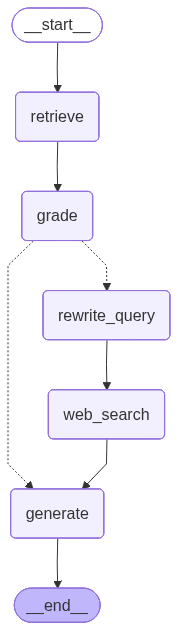

In [82]:
from IPython.display import display,Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [84]:
graph.invoke({"question":"What supervisor agent?"})["generation"]

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO THE QUERY---
---GRADE: DOCUMENT NOT RELEVANT---
---DECIDE TO GENERATE OR RE-WRITE QUERY---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---REWRITE QUERY---
What is a supervisor agent?
---WEB SEARCH---
---Generate---


AIMessage(content='A supervisor agent is a specialized AI agent that manages and coordinates multi-agent flow, serving as a central hub that collects input, maintains structured memory, and orchestrates the execution of sub-agents based on predefined logic. It routes relevant requests and tasks to the appropriate collaborator agent, ensuring efficient and structured execution. The supervisor agent is used to oversee and manage other agents, breaking down user requests into tasks and coordinating the results.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1936, 'total_tokens': 2022, 'completion_time': 0.193968272, 'prompt_time': 0.053758185, 'queue_time': 0.099734837, 'total_time': 0.247726457}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--2c9e2360-ceb2-4118-bcd0-5524aad0a